The purpose of this notebook is primarily to test out some basic (though non-trivial) image classification training using TensorFlow (specifically, the Estimator and Dataset APIs). I'd also like to get some practical experience with the effects of data augmentation, batch-size vs learning rate decay tradeoffs, and how adaptive optimizers like Adam compare with more traditional methods like SGD with momentum. This is also a nice opportunity to get used to doing training with a GPU on Colab.

I'm working with a more or less exact copy of the ResNet architecture (of modest size, 32 layers total), with the pre-activation modifications made in subsequent papers: batch-norm-ReLU before all convolutions, minimal transformation on the shortcut connections in each residual block. The dataset we'll work with is CIFAR-10, because it's easy/quick to train and because there are already nice pre-packaged functions for retrieving and loading it in TensorFlow, inside the Keras module.

The first few lines here is just some code for getting things set up on a Colab VM instance.

In [0]:
!git clone https://github.com/smeenehan/TensorFlowProjects.git

In [0]:
!pip install scikit-optimize

In [0]:
%cd /content/TensorFlowProjects/CIFAR

In [0]:
LOG_DIR_ROOT = '/tmp/logs'
get_ipython().system_raw('tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format(LOG_DIR_ROOT))

In [2]:
import matplotlib.pyplot as plt
from model import model_fn
import numpy as np
from os import path
import skopt
from skopt.plots import plot_evaluations, plot_convergence, plot_objective
import tensorflow as tf
import utils
%matplotlib inline

In [0]:
tf.logging.set_verbosity(tf.logging.WARN)

First, let's define some wrappers for training/evaluation, making log directories, and reading/plotting log file data

In [0]:
def train_eval_loop(log_dir, num_epochs, params, train, val):
    """Basic train-evaluate loop. Builds an estimator and logs validation
    accuracy after every epoch. 

    Parameters
    ----------
    log_dir : string
        Directory in which to log event files and Estimator checkpoints 
    num_epochs : int
        Number of "epochs" to run the loop. If the training dataset repeats, the
        actual number of epochs is this number times the repeat number
    params : dictionary
        Dictionary of hyper-parameters to use in the Estimator
    train : dataset
        Training dataset, should not repeat infinitely
    eval : dataset
        Evaluation dataset, should not repeat infinitely

    Returns
    -------
    float
        Best validation accuracy seen during the loop.
    """
    estimator = tf.estimator.Estimator(
        model_fn, model_dir=log_dir, params=params, 
        config=tf.estimator.RunConfig(keep_checkpoint_max=1))
    best_accuracy = 0
    for idx in range(num_epochs):
        estimator.train(train)
        metric_dict = estimator.evaluate(val)
        accuracy = metric_dict['accuracy']
        if accuracy > best_accuracy:
            best_accuracy = accuracy
    return accuracy

In [0]:
def log_dir_name(log_dir_root, optim_type, learning_rate, reg_scale, momentum=None):
    log_dir = log_dir_root+'/'+optim_type+'/'
    if isinstance(learning_rate, list):
        log_dir += 'lr_decay_reg_%.3g' % reg_scale
    else:
        log_dir += 'lr_%.3g_reg_%.3g' % (learning_rate, reg_scale)
    if optim_type is 'Momentum':
        if momentum is None:
            raise ValueError('Must specify momentum when using optim_type = \'Momentum\'')
        log_dir += '_mom_%.2g' % momentum
    return log_dir

In [16]:
def read_csv_log(file_path):
    data = np.loadtxt(file_path, delimiter=',', skiprows=1)
    time = data[:, 0]/60
    time -= time[0]
    steps = data[:, 1]
    values = data[:, 2]
    return values, steps, time

In [39]:
def plot_training_results(log_dir, base_name, steps_to_epochs=None):
    file_path_root = path.join(log_dir, base_name)
    train_acc, train_steps, train_time = read_csv_log(file_path_root+'-tag-accuracy.csv')
    eval_acc, eval_steps, eval_time = read_csv_log(file_path_root+'_eval-tag-accuracy.csv')
    train_loss, _, _ = read_csv_log(file_path_root+'-tag-loss.csv')
    eval_loss, _, _ = read_csv_log(file_path_root+'_eval-tag-loss.csv')
    
    x_label = 'training steps'
    if steps_to_epochs:
        train_steps *= steps_to_epochs
        eval_steps *= steps_to_epochs
        x_label = 'epochs'
        
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15, 5))
    ax_loss.semilogy(train_steps, train_loss, 'b', label='train')
    ax_loss.semilogy(eval_steps, eval_loss, 'r--', label='test')
    ax_loss.set_xlabel(x_label)
    ax_loss.set_ylabel('loss')
    ax_loss.legend()
    ax_loss_2 = ax_loss.twiny()
    ax_loss_2.set_xlim(train_time[0], train_time[-1])
    ax_loss_2.set_xlabel('time (min)')
    
    ax_acc.semilogy(train_steps, train_acc, 'b', label='train')
    ax_acc.semilogy(eval_steps, eval_acc, 'r--', label='test')
    ax_acc.set_xlabel(x_label)
    ax_acc.set_ylabel('accuracy')
    ax_acc.legend()
    ax_acc_2 = ax_acc.twiny()
    ax_acc_2.set_xlim(train_time[0], train_time[-1])
    ax_acc_2.set_xlabel('time (min)')
    
    plt.tight_layout()
    plt.show()

# SGD training

Let's check that we can get the same results as the original ResNet paper. So, learning rate of 0.1, decaying by 10 at ~82 and 123 epochs (32k and 48k iterations with this batch size), and training for a total of 150 epochs (~60k iterations). Weight decay ($L_2$ regularization) is set at $10^{-4}$, momentum at 0.9, and we augment the training set with random crops and flips, using a batch size of 128.

The original ResNet paper got a testing accuracy on CIFAR10 of ~91.3-92.5% with a 20-32 layer ResNet. We're using the variation on the original net architecture described in *Identity Mappings in Deep Residual Networks*, with full pre-activation, and 3 residual blocks per residual stage (29 layers total including the final FC layer). They didn't explicitly test that size in the latter paper, but we expect a similar testing error in the low 90% range.

In [0]:
_, data_format = utils.device_and_data_format()
batch_size = 128
shuffle = 5000
train, test, _ = utils.get_CIFAR10_data(data_format, batch_size=batch_size, 
                                        shuffle=shuffle, augment=True)
train_input_fn = lambda: train.repeat(5).make_one_shot_iterator().get_next()
test_input_fn = lambda: test.make_one_shot_iterator().get_next()

In [11]:
learning_rate= [[32000, 48000], [0.1, 0.01, 0.001]]
reg_scale = 0.0001
momentum = 0.9
log_dir = log_dir_name(LOG_DIR_ROOT, 'Momentum', learning_rate, reg_scale, momentum)
params = {'learning_rate': learning_rate, 'reg_scale': reg_scale, 'momentum': momentum, \
          'optim_type': 'Momentum', 'data_format': data_format}
train_eval_loop(log_dir, 30, params, train_input_fn, test_input_fn)

0.9177

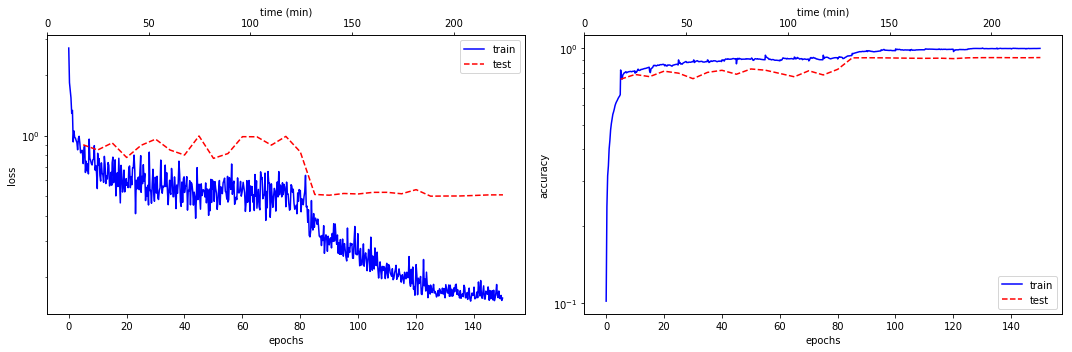

In [38]:
plot_training_results(path.join('logs','2018_5_3_Colab'), 
                      'run_2018_5_3_Colab_Momentum_lr_decay_reg_0.0001_mom_0.9_aug_batch_128', 
                      steps_to_epochs=128/50000)

Okay, cool! Training curves look basically as expected, and we got an accuracy of 91.8%, right where we expect based on the ResNet paper. It is worth noting this took 3h54m total to train, vs 2h37m using an earlier version of the code (not supporting augmentation). A couple major differences there are: training on the full training set with evaluations on the test set, vs training on 98% of the training set and evaluation on a validation set of 1000 images, plus data augmentation.

From the volume of data alone, we would expect only about a 5.6% increase in runtime, so the augmentation is probably adding a significant portion of runtime here. One issue is that, since the random crop and flip functions in TensorFlow are applied on a per-image basis, the preprocessing map must now precede batching in the data pipeline. Another issue is that, when using the NCHW format for tensors, we delay tranposition of the channels until this point as well, since the built-in image processing functions in TensorFlow only work on data in NHWC format. My guess is that these two things slow things down noticeably.

We can check this by training on a non-augmented dataset. This still has pre-processing and transposition done per-image, but now the pre-processing is just subtraction of the mean. This will also let us see how much augmentation is really helping the training accuracy here.

In [0]:
_, data_format = utils.device_and_data_format()
batch_size = 128
shuffle = 5000
train, test, _ = utils.get_CIFAR10_data(data_format, batch_size=batch_size, 
                                        shuffle=shuffle, augment=False)
train_input_fn = lambda: train.repeat(5).make_one_shot_iterator().get_next()
test_input_fn = lambda: test.make_one_shot_iterator().get_next()

In [9]:
learning_rate= [[32000, 48000], [0.1, 0.01, 0.001]]
reg_scale = 0.0001
momentum = 0.9
log_dir = log_dir_name(LOG_DIR_ROOT, 'Momentum', learning_rate, reg_scale, momentum)+'_no_aug'
params = {'learning_rate': learning_rate, 'reg_scale': reg_scale, 'momentum': momentum, \
          'optim_type': 'Momentum', 'data_format': data_format}
train_eval_loop(log_dir, 30, params, train_input_fn, test_input_fn)

0.8658

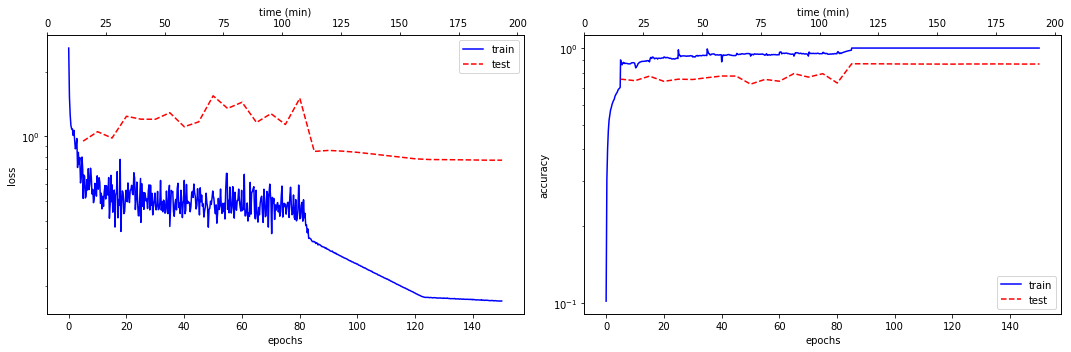

In [41]:
plot_training_results(path.join('logs','2018_5_3_Colab'), 
                      'run_Momentum_lr_decay_reg_0.0001_mom_0.9_no_aug_batch_128', 
                      steps_to_epochs=128/50000)

Note that the accuracy on the test set took quite a hit: down to 86.6%, so the augmentation is giving us ~5% better final accuracy after training.

This still took a fair amount of time, about 3h24m. We can thus conclude that most of the slowdown is due to the fact the pre-processing is now done per-image and includes transposition of the channels. Wonder if it would be faster to just always have channels last? Supposedly NCHW ordering is optimal for GPU computation, but maybe it's not a big enough deal? The way I wrote the data pipeline, if I force `data_format = 'channels_last'` we won't do the transposition at all.

So, let's do this once more, with NHWC ordering and no augmentation.

In [0]:
data_format = 'channels_last'
batch_size = 128
shuffle = 5000
train, test, _ = utils.get_CIFAR10_data(data_format, batch_size=batch_size, 
                                        shuffle=shuffle, augment=False)
train_input_fn = lambda: train.repeat(5).make_one_shot_iterator().get_next()
test_input_fn = lambda: test.make_one_shot_iterator().get_next()

In [10]:
learning_rate= [[32000, 48000], [0.1, 0.01, 0.001]]
reg_scale = 0.0001
momentum = 0.9
log_dir = log_dir_name(LOG_DIR_ROOT, 'Momentum', learning_rate, reg_scale, momentum)+'_no_aug_NHWC'
params = {'learning_rate': learning_rate, 'reg_scale': reg_scale, 'momentum': momentum, \
          'optim_type': 'Momentum', 'data_format': data_format}
train_eval_loop(log_dir, 30, params, train_input_fn, test_input_fn)

0.8639

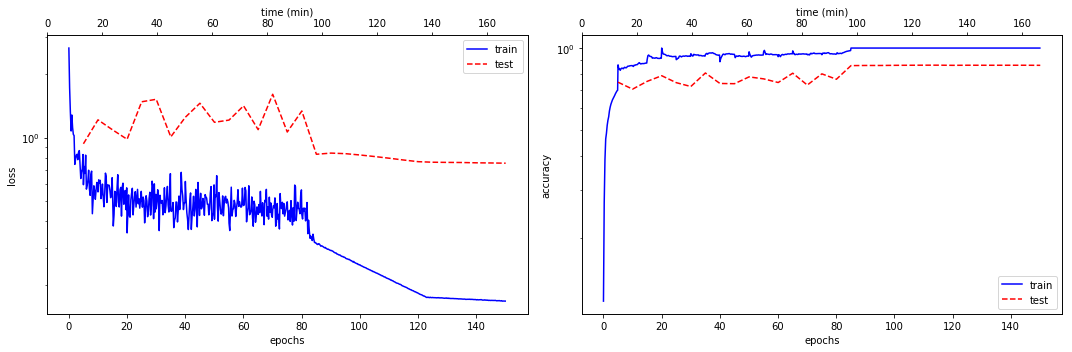

In [42]:
plot_training_results(path.join('logs','2018_5_3_Colab'), 
                      'run_Momentum_lr_decay_reg_0.0001_mom_0.9_no_aug_NHWC_batch_128', 
                      steps_to_epochs=128/50000)

Okay, that took 2h55m. So, in this case any GPU inefficiency due to NHWC vs NCHW ordering isn't slowing things down enough to compensate for the slowdown due to per-image/per-batch transposition in the pre-processing. So, going forward we'll just use the NCHW ordering.

Now, I thought it would be interesting to look at batch size dependence, but what would really be interesting there is looking at dynamic batch sizing (e.g., increase batch size periodically rather than decay the learning rate to improve the wall-clock time). It would also be interesting to look at test error vs batch size for constant size. Generalization should get worse for larger batches, though it's unclear when this kicks in. Looking at fixed batch size variations is easier for now, so let's play around with that.

Realistically, as we change batch size, we might do another hyper-parameter search, but we know that the noise-scale of SGD should roughly scale as $g \sim \epsilon N/B$, where $\epsilon$ is the learning rate, $N$ the training set size, and $B$ the batch size. So, we'll try increasing and decreasing the batch size by 4x, and adjust the learning rate and decay steps appropriately, just to see how well that does. Hopefully we'll basically get the same results.

In [0]:
data_format = 'channels_last'
batch_size = 32
shuffle = 5000
train, test, _ = utils.get_CIFAR10_data(data_format, batch_size=batch_size, 
                                        shuffle=shuffle, augment=True)
train_input_fn = lambda: train.repeat(5).make_one_shot_iterator().get_next()
test_input_fn = lambda: test.make_one_shot_iterator().get_next()

In [77]:
learning_rate= [[128000, 192000], [0.025, 0.0025, 0.00025]]
reg_scale = 0.0001
momentum = 0.9
log_dir = log_dir_name(LOG_DIR_ROOT, 'Momentum', learning_rate, reg_scale, momentum)+'_reduce_batch'
params = {'learning_rate': learning_rate, 'reg_scale': reg_scale, 'momentum': momentum, \
          'optim_type': 'Momentum', 'data_format': data_format}
train_eval_loop(log_dir, 30, params, train_input_fn, test_input_fn)

0.9087


Similarly, if we increase by a factor of 4, but are more aggressive with the training rate, we should get similar effects.

In [0]:
data_format = 'channels_last'
batch_size = 512
shuffle = 5000
train, test, _ = utils.get_CIFAR10_data(data_format, batch_size=batch_size, 
                                        shuffle=shuffle, augment=True)
train_input_fn = lambda: train.repeat(5).make_one_shot_iterator().get_next()
test_input_fn = lambda: test.make_one_shot_iterator().get_next()

In [10]:
learning_rate= [[8000, 12000], [0.4, 0.04, 0.004]]
reg_scale = 0.0001
momentum = 0.9
log_dir = log_dir_name(LOG_DIR_ROOT, 'Momentum', learning_rate, reg_scale, momentum)+'_increase_batch'
params = {'learning_rate': learning_rate, 'reg_scale': reg_scale, 'momentum': momentum, \
          'optim_type': 'Momentum', 'data_format': data_format}
train_eval_loop(log_dir, 30, params, train_input_fn, test_input_fn)

0.9167

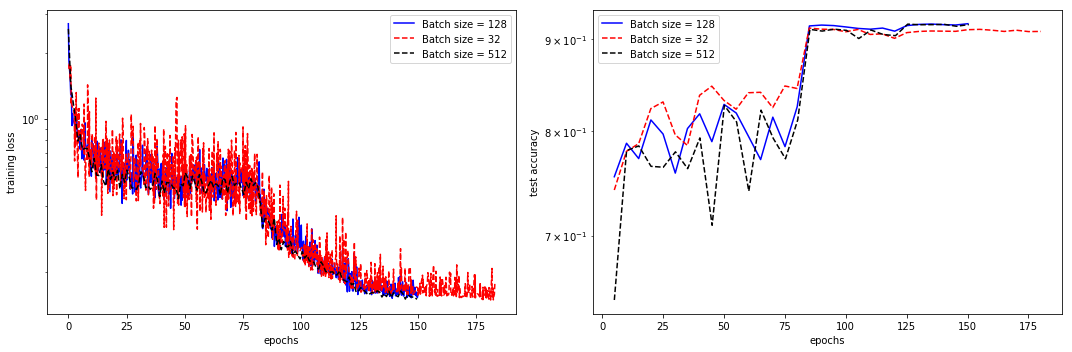

Total training time, 150 epochs, batch size = 128: 228 min
Total training time, 150 epochs, batch size = 32: 316 min
Total training time, 150 epochs, batch size = 512: 188 min


In [75]:
file_path_root = path.join('logs', '2018_5_3_Colab')
SGD_128_acc, SGD_128_eval_steps, SGD_128_time = read_csv_log(
    path.join(file_path_root, 'run_2018_5_3_Colab_Momentum_lr_decay_reg_0.0001_mom_0.9_aug_batch_128_eval-tag-accuracy.csv'))
SGD_128_loss, SGD_128_train_steps, _ = read_csv_log(
    path.join(file_path_root, 'run_2018_5_3_Colab_Momentum_lr_decay_reg_0.0001_mom_0.9_aug_batch_128-tag-loss.csv'))
SGD_128_eval_steps *= 128/50000
SGD_128_train_steps *= 128/50000

file_path_root = path.join('logs', '2018_5_14_Colab')
SGD_32_acc, SGD_32_eval_steps, SGD_32_time = read_csv_log(
    path.join(file_path_root, 'run_Momentum_lr_decay_reg_0.0001_mom_0.9_reduce_batch_eval-tag-accuracy.csv'))
SGD_32_loss, SGD_32_train_steps, _ = read_csv_log(
    path.join(file_path_root, 'run_Momentum_lr_decay_reg_0.0001_mom_0.9_reduce_batch-tag-loss.csv'))
SGD_32_eval_steps *= 32/50000
SGD_32_train_steps *= 32/50000

SGD_512_acc, SGD_512_eval_steps, SGD_512_time = read_csv_log(
    path.join(file_path_root, 'run_Momentum_lr_decay_reg_0.0001_mom_0.9_increase_batch_eval-tag-accuracy.csv'))
SGD_512_loss, SGD_512_train_steps, _ = read_csv_log(
    path.join(file_path_root, 'run_Momentum_lr_decay_reg_0.0001_mom_0.9_increase_batch-tag-loss.csv'))
SGD_512_eval_steps *= 512/50000
SGD_512_train_steps *= 512/50000

fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15, 5))
ax_loss.semilogy(SGD_128_train_steps, SGD_128_loss, 'b', label='Batch size = 128')
ax_loss.semilogy(SGD_32_train_steps, SGD_32_loss, 'r--', label='Batch size = 32')
ax_loss.semilogy(SGD_512_train_steps, SGD_512_loss, 'k--', label='Batch size = 512')
ax_loss.set_xlabel('epochs')
ax_loss.set_ylabel('training loss')
ax_loss.legend()

ax_acc.semilogy(SGD_128_eval_steps, SGD_128_acc, 'b', label='Batch size = 128')
ax_acc.semilogy(SGD_32_eval_steps, SGD_32_acc, 'r--', label='Batch size = 32')
ax_acc.semilogy(SGD_512_eval_steps, SGD_512_acc, 'k--', label='Batch size = 512')
ax_acc.set_xlabel('epochs')
ax_acc.set_ylabel('test accuracy')
ax_acc.legend()

plt.tight_layout()
plt.show()

tot_time_128 = SGD_128_time[-1]-SGD_128_time[0]
tot_time_32 = SGD_32_time[-7]-SGD_32_time[0] # Accidentally trained this run way longer
tot_time_512 = SGD_512_time[-1]-SGD_512_time[0]
print('Total training time, 150 epochs, batch size = 128: %d min' % tot_time_128)
print('Total training time, 150 epochs, batch size = 32: %d min' % tot_time_32)
print('Total training time, 150 epochs, batch size = 512: %d min' % tot_time_512)

These all trained with roughly comparable results, indicating that the rough scaling relation between learning rate and batch size works pretty well. Note that the small batch size of 32 had slightly worse performance, though in the early phases had better generalization. The early performance gains may be due to the larger noise scale sampling more of the optimization space. The poorer generalization performance may be due to the coupling between learning rate and regularization strength due to the way $L_2$ regularization is implemented in TensorFlow (see the discussion below when we try the Adam optimizer). We kept the noise scale roughly constant by reducing the learning rate, but may have needed to increase the regularization scale to compensate.

Also notice that, as expected, the wall clock time to run through the same number of epochs reduces the larger we make the batch size. It's a very sublinear increase, but at least up to batch sizes of 512 there's nothing but upside to using larger training batches, though the overall effect on performance is negligible.

# Adam training

We don't know good hyper-parameters *a priori*, so let's do a search. We'll use scikit-optimize to help with this. First, we need a fitness function to optimize. Here, we'll train the test set for some number of epochs (set by the dataset `repeat` command) and look at accuracy on a validation set, and we'll minimize negative accuracy. If the optimization fails (e.g., divergence due to too large of a training rate) we'll just return a large positive number (non-errors are bounded between -1 and 0).

For our training, we'll do a 45k/5k train/val split, and to start we'll do a very coarse search while training for only 5 epochs.

In [0]:
batch_size = 128
shuffle = 5000
train, test, val = utils.get_CIFAR10_data('channels_last', batch_size=batch_size, 
                                          shuffle=shuffle, num_val=5000, augment=True)
train_input_fn = lambda: train.repeat(5).make_one_shot_iterator().get_next()
val_input_fn = lambda: val.make_one_shot_iterator().get_next()
test_input_fn = lambda: test.make_one_shot_iterator().get_next()

In [0]:
def fitness_Adam(x):
    learning_rate, reg_scale = x
    log_dir = log_dir_name(LOG_DIR_ROOT, 'Adam', learning_rate, reg_scale)
    params = {'learning_rate': learning_rate, 'reg_scale': reg_scale, \
              'optim_type': 'Adam', 'data_format': 'channels_last'}
    try:
        status_str = 'lr = %.3g, reg = %.3g : ' % (learning_rate, reg_scale)
        print(status_str, end='')
        accuracy = train_eval_loop(log_dir, 1, params, train_input_fn, val_input_fn)
        print(accuracy)
        return -accuracy
    except KeyboardInterrupt:
        raise KeyboardInterrupt('User stopped process')
    except:
        print('fail')
        return 10

In [0]:
dimensions_Adam = [skopt.space.Real(1e-4, 1, 'log-uniform', name='learning_rate'),
                   skopt.space.Real(1e-6, 1, 'log-uniform', name='reg_scale')]
default_Adam = [0.01, 0.001]

In [32]:
search_result  = skopt.gp_minimize(func=fitness_Adam,
                                   dimensions=dimensions_uAdam,
                                   acq_func='EI',
                                   n_calls=25,
                                   x0=default_Adam)

lr = 0.01, reg = 0.001 : 0.3184
lr = 0.005, reg = 0.0157 : 0.2612
lr = 0.771, reg = 2.48e-06 : 0.1468
lr = 0.234, reg = 1.29e-05 : 0.3052
lr = 0.108, reg = 1.65e-06 : 0.3406
lr = 0.204, reg = 1.6e-06 : 0.2486
lr = 0.000485, reg = 0.00023 : 0.6864
lr = 0.191, reg = 6.58e-05 : 0.1836
lr = 0.00378, reg = 0.0871 : 0.2148
lr = 0.267, reg = 0.0123 : 0.0958
lr = 0.000281, reg = 0.0391 : 0.5242
lr = 0.0001, reg = 1e-06 : 0.5632
lr = 0.0001, reg = 0.000256 : 0.5478
lr = 0.000799, reg = 1e-06 : 0.6832
lr = 0.000626, reg = 1e-06 : 0.6592
lr = 0.000537, reg = 1.13e-05 : 0.6682
lr = 0.00164, reg = 1e-06 : 0.6988
lr = 0.0019, reg = 1e-06 : 0.7378
lr = 0.00345, reg = 1e-06 : 0.7042
lr = 0.00307, reg = 1e-06 : 0.6986
lr = 0.00147, reg = 1.01e-05 : 0.7042
lr = 0.0015, reg = 9.34e-06 : 0.7474
lr = 0.00157, reg = 1.23e-05 : 0.6288
lr = 0.0001, reg = 1 : 0.1976
lr = 0.00574, reg = 1e-06 : 0.6282


In [33]:
search_result.x

[0.001497241072721861, 9.341315464608985e-06]

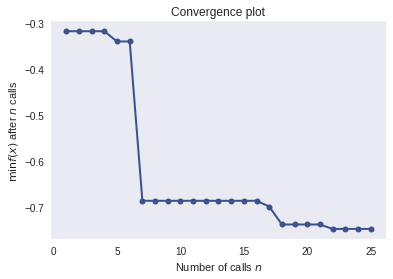

In [34]:
_ = plot_convergence(search_result)

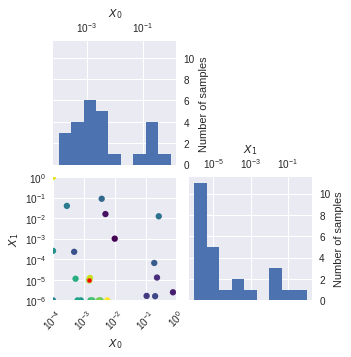

In [35]:
_ = plot_evaluations(search_result, bins=10)

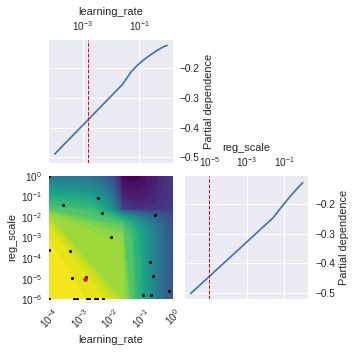

In [36]:
_ = plot_objective(result=search_result, dimensions=['learning_rate', 'reg_scale'], levels=50)

Looks like a general trend towards small learning rates and small regularization strength. The latter could have something to do with some issues related to $L_2$ regularization plus adaptive optimizers. 

Basically, the way it is implemented in TensorFlow (and all other popular machine learning libraries) is to add the $L_2$ norm of the weights to the loss function. This means that in the update step the "weight decay"-like term is multiplied by the learning rate. For SGD this is no big thing; the weight decay strength is just scaled (this isn't *quite* true for SGDM, but is quite close enough). Technically, this means that the weight decay and learning rate are coupled, and technically speaking we should change the regularization strength when we change the learning rate, but in general it's still pretty close to vanilla weight decay.

For adaptive optimizers, though, the non-uniform scaling of learning rates across the different weights applies to regularization as well. This means that $L_2$ norm regularization is very much *not* equivalent to weight decay, as indicated by a recent paper (*Fixing Weight Decay Regularization in Adam*). In particular, since weights don't decay at the same rate, the usual effect of $L_2$ regularization of giving us small, relatively evenly distributed weight vectors will not really be true.

Still, let's roll with this for now. We could do a narrower search, but the adaptive optimizers are supposed to be less sensitive to getting the learning rate just right (isn't that kind of the point?), so let's just try training.

In [0]:
batch_size = 128
shuffle = 5000
train, test, _ = utils.get_CIFAR10_data('channels_last', batch_size=batch_size, 
                                          shuffle=shuffle, augment=True)
train_input_fn = lambda: train.repeat(5).make_one_shot_iterator().get_next()
test_input_fn = lambda: test.make_one_shot_iterator().get_next()

In [23]:
learning_rate= 0.0015
reg_scale = 1e-5
log_dir = log_dir_name(LOG_DIR_ROOT, 'Adam', learning_rate, reg_scale)
params = {'learning_rate': learning_rate, 'reg_scale': reg_scale, \
          'optim_type': 'Adam', 'data_format': 'channels_last'}
train_eval_loop(log_dir, 30, params, train_input_fn, test_input_fn)

0.8528

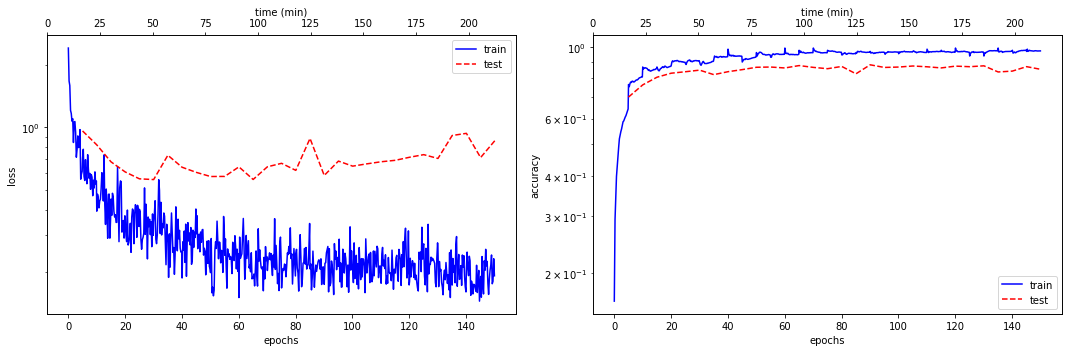

In [45]:
plot_training_results(path.join('logs','2018_5_3_Colab'), 
                      'run_Adam_lr_0.0015_reg_1e-05', 
                      steps_to_epochs=128/50000)

Not too great. Let's do some direct comparison to our best SGD data, just looking at test accuracy.

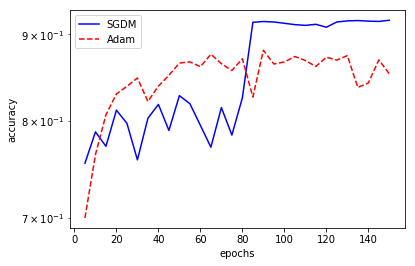

In [47]:
file_path_root = path.join('logs', '2018_5_3_Colab')
SGD_acc, SGD_steps, _ = read_csv_log(
    path.join(file_path_root, 'run_2018_5_3_Colab_Momentum_lr_decay_reg_0.0001_mom_0.9_aug_batch_128_eval-tag-accuracy.csv'))
Adam_acc, Adam_steps, _ = read_csv_log(
    path.join(file_path_root, 'run_Adam_lr_0.0015_reg_1e-05_eval-tag-accuracy.csv'))
SGD_steps *= 128/50000
Adam_steps *= 128/50000

plt.semilogy(SGD_steps, SGD_acc, 'b', label='SGDM')
plt.semilogy(Adam_steps, Adam_acc, 'r--', label='Adam')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

Noticeably worse than SGD. Actually, about as good as SGD when we didn't do data-augmentation. However, notice that Adam converges almost twice as fast to its best accuracy. This is generally in line with what some people see with adaptive optimizers; they are more forgiving in terms of hyper-parameters and train quicker, but can have notably worse generalization performance compared with carefully tuned SGD.

Now, given the issues with $L_2$ regularization plus Adam, we could try making a modified optimizer to implement proper, uniform, decoupled weight decay. Or, we could just abandon explicit regularization altogether and see if just batch-norm alone (maybe with some dropout) is sufficient to give good generalization performance.

However, given the cumbersome nature of making code mods while workin on Colab, and my lack of a personal GPU-enabled computer to play with, I might shelve this for now and move on to more interesting stuff.